In [ ]:
# -*- coding: utf-8 -*-
"""
This takes the data for one ppt in one session and organises it into
two arrays, one for left and one for right motor imagery data. 
All data not related to the MI trials is disregarded.
"""
import numpy as np
import glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional

import scipy.io as spio
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


In [ ]:
def figure(History, legend):
  ####################### PLOT TRAINING VS VALIDATION ######################
  ########## Accuracy ###########
  acc = History.history['acc']
  val_acc = History.history['val_acc']
  loss = History.history['loss']
  val_loss = History.history['val_loss']

  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.grid()
  plt.show()

  ########## Loss ###########
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  try:
    loss_no_reg = History.history['categorical_crossentropy']
    val_loss_no_reg = History.history['val_categorical_crossentropy']
    plt.plot(loss_no_reg)
    plt.plot(val_loss_no_reg)
    plt.legend(legend + [legend[0]+' sin reg', legend[1]+' sin reg'], loc='upper left')
  except:
    plt.legend(legend, loc='upper left')

  plt.grid()
  plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving P1_post_test.mat to P1_post_test.mat
Saving P1_post_training.mat to P1_post_training.mat
Saving P1_pre_test.mat to P1_pre_test.mat
Saving P1_pre_training.mat to P1_pre_training.mat
Saving P2_post_test.mat to P2_post_test.mat
Saving P2_post_training.mat to P2_post_training.mat
Saving P2_pre_test.mat to P2_pre_test.mat
Saving P2_pre_training.mat to P2_pre_training.mat
Saving P3_post_test.mat to P3_post_test.mat
Saving P3_post_training.mat to P3_post_training.mat
Saving P3_pre_test.mat to P3_pre_test.mat
Saving P3_pre_training.mat to P3_pre_training.mat


In [ ]:
# #change path
path_TRAIN = r'/content/P3_post_training.mat' # use your path
path_test = r'/content/P3_post_test.mat' # use your path
path = r'/content'
files_TRAIN = glob.glob(path + "/*training.mat")
files_test = glob.glob(path + "/*test.mat")

mat_TRAIN = spio.loadmat(path_TRAIN, squeeze_me=True)
mat_test = spio.loadmat(path_test, squeeze_me=True)


In [ ]:
def extract(mat):
  # path = 'C:\Users\Rosana\Documents\GTEC\stroke\P1_pre_training.mat'
  # mat = spio.loadmat(path, squeeze_me=True)

  print("The keys of this data dictionary for this ppt are :", mat.keys())
  triggers = mat['trig']
  fs = mat['fs']
  eeg_data = mat['y']
  print("There are ", len(triggers), " triggers")
  print(max(triggers)) 
  print("sampling frequency is ", mat['fs'])
  print("Length of data set is ", len(eeg_data))




  # get indices that indicate change in blocks, such as 000s then 1111s in order to split these
  v=np.asarray(triggers)
  indices = np.where(np.diff(v,prepend=np.nan))[0]
  #print(indices)

  listvalues = []
  listclasses = []
  ind = 0
  for ind in range(0, len(indices)-1):
      listclasses.append(triggers[indices[ind]]) # means we know which class each block relates to
      listvalues.append(eeg_data[indices[ind]:indices[ind+1]]) # gets the block as a subset


  # splits the data into the two separate conditions left and right, removes 0 triggers
  # this also means each trial should now be equal length so can be put into an array
  left_class = []
  left_value = []
  right_class = []
  right_value = []

  for i,x in enumerate(listclasses):
      if x ==1:
          left_class.append(listclasses[i])
          left_value.append(listvalues[i])
      elif x ==-1:
          right_class.append(listclasses[i])
          right_value.append(listvalues[i])
          
  # only keep data with relevant time points, 2 till 8 seconds
  start_point = 2*fs
  end_point = 8*fs
  left_value_trial = []
  right_value_trial = []
  for trial in left_value:
      left_value_trial.append(trial[start_point:end_point])
  for trial in right_value:
      right_value_trial.append(trial[start_point:end_point])
          

  left_data = np.asarray(left_value_trial)
  right_data = np.asarray(right_value_trial)
  print(left_data.shape, right_data.shape)
  left_labels = np.ones(len(left_data))
  right_labels = np.zeros(len(right_data))
  print(right_labels)

  return left_data, left_labels, right_data, right_labels

In [ ]:
left_data, left_labels, right_data, right_labels = extract(mat_TRAIN)

The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  206504  triggers
1
sampling frequency is  256
Length of data set is  206504
(40, 1536, 16) (40, 1536, 16)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print('X right: (samples, time, features) =', right_data.shape)
print('Y right: (sample labels) =', right_labels.shape)
print('X left: (samples, time, features) =', left_data.shape)
print('Y left: (sample labels) =', left_labels.shape)


X right: (samples, time, features) = (40, 1536, 16)
Y right: (sample labels) = (40,)
X left: (samples, time, features) = (40, 1536, 16)
Y left: (sample labels) = (40,)


In [ ]:
x_TRAIN_orig = np.concatenate((right_data, left_data), axis = 0)
y_TRAIN_orig = np.concatenate((right_labels, left_labels), axis = 0)

In [ ]:
left_data, left_labels, right_data, right_labels = extract(mat_test)


The keys of this data dictionary for this ppt are : dict_keys(['__header__', '__version__', '__globals__', 'fs', 'trig', 'y'])
There are  218432  triggers
1
sampling frequency is  256
Length of data set is  218432
(40, 1536, 16) (40, 1536, 16)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
x_test_orig = np.concatenate((right_data, left_data), axis = 0)
y_test_orig = np.concatenate((right_labels, left_labels), axis = 0)

In [ ]:
def windowed(x,windows_size, overlap_factor = 0):
  fs = 256
  pieces = len(x[0])//windows_size
  temp1 = []
  temp2 = []
  overlap = int(windows_size*overlap_factor)

  for j in range(len(x)):
    temp1 = []
    i = 0
    init_index = 0 
    last_index = windows_size
    while len(x[j][init_index:last_index]) == windows_size:
      temp_data = x[j][init_index:last_index]#[0:-1:20,:]
      temp1.append(np.concatenate((np.mean(temp_data, axis = 0), np.std(temp_data, axis = 0), skew(temp_data, axis = 0), kurtosis(temp_data, axis = 0)), axis = 0) ) #, np.var(temp_data, axis = 0) ])
      #temp1.append(temp_data )
      init_index = init_index + windows_size - overlap
      last_index = last_index + windows_size - overlap
      
    temp2.append(np.asarray(temp1).reshape([-1,32]))
    #temp2.append(np.asarray(temp1))
    
  return np.asarray(temp2)



In [ ]:
x_TRAIN_orig2 = np.squeeze(windowed(x_TRAIN_orig, 500))
x_test_orig2 = np.squeeze(windowed(x_test_orig, 500))

scaler = MinMaxScaler()
max_value = np.max(x_TRAIN_orig2, axis=(0,1))
min_value = np.min(x_TRAIN_orig2, axis=(0,1))

x_TRAIN = (x_TRAIN_orig2-min_value)/(max_value-min_value)
x_test = (x_test_orig2-min_value)/(max_value-min_value)


In [ ]:
x_TRAIN_orig.shape

(80, 1536, 16)

In [ ]:
x_TRAIN_orig2.shape

(80, 6, 32)

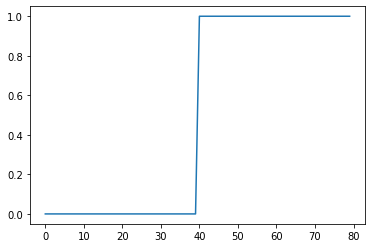

In [ ]:
plt.plot(y_TRAIN_orig)

In [ ]:
np.max(x_test)

4.814260755615846

In [ ]:
model = tf.keras.models.Sequential([
  Bidirectional(tf.keras.layers.LSTM(2, return_sequences=True), input_shape=(x_TRAIN.shape[1],x_TRAIN.shape[2]) ),
  Bidirectional(tf.keras.layers.LSTM(2, return_sequences=True)),
  Bidirectional(tf.keras.layers.LSTM(2)),
  tf.keras.layers.Dense(1, activation = sigmoid),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=["acc"])
history = model.fit(x_TRAIN, y_TRAIN_orig, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
3/3 [==============================] - 7s 12ms/step - loss: 0.6932 - acc: 0.5156
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6932 - acc: 0.5156
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6927 - acc: 0.5352
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.6936 - acc: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6942 - acc: 0.4805
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6933 - acc: 0.5117
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6937 - acc: 0.4961
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.6937 - acc: 0.5000
Epoch 9/100
3/3 [==============================] - 0s 10ms/step - loss: 0.6934 - acc: 0.5039
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.6935 - acc: 0.5078
Epoch 11/100
3/3 [==============================] - 0s 16ms/step - lo

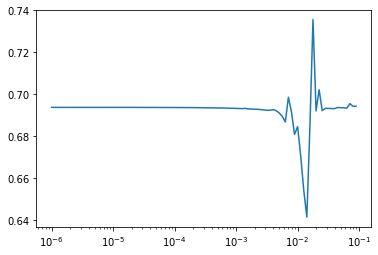

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])


In [ ]:
model = tf.keras.models.Sequential([
  Bidirectional(tf.keras.layers.LSTM(2, return_sequences=True), input_shape=(x_TRAIN.shape[1],x_TRAIN.shape[2]) ),
  Bidirectional(tf.keras.layers.LSTM(2, return_sequences=True)),
  Bidirectional(tf.keras.layers.LSTM(2)),
  tf.keras.layers.Dense(1, activation = sigmoid),
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_24 (Bidirectio (None, 3, 4)              1072      
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 3, 4)              112       
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 4)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=2e-3)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=["acc"])
# Early stopping
stopping = EarlyStopping(monitor='val_loss',min_delta=0,mode='auto',patience=20, restore_best_weights=True)

history = model.fit(x_TRAIN, y_TRAIN_orig, callbacks=[stopping] , validation_data = (x_test, y_test_orig), epochs=2000)


Epoch 1/2000
3/3 [==============================] - 9s 832ms/step - loss: 0.6936 - acc: 0.3914 - val_loss: 0.6932 - val_acc: 0.4875
Epoch 2/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.6932 - acc: 0.4617 - val_loss: 0.6932 - val_acc: 0.4875
Epoch 3/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.6932 - acc: 0.4961 - val_loss: 0.6931 - val_acc: 0.5125
Epoch 4/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.6934 - acc: 0.4508 - val_loss: 0.6930 - val_acc: 0.5125
Epoch 5/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.6931 - acc: 0.4922 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.6933 - acc: 0.4648 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 7/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.6930 - acc: 0.4805 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 8/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.6929 - 

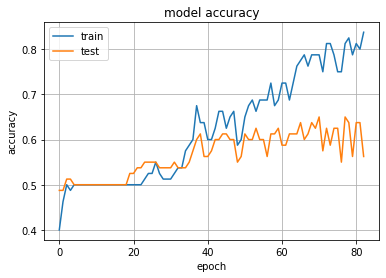

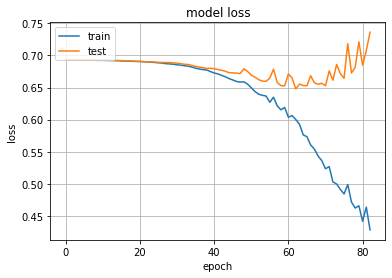

In [ ]:
figure(history, ['train', 'test'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


3/3 [==============================] - 0s 6ms/step - loss: 0.6480 - acc: 0.6125


[0.6479713916778564, 0.612500011920929]

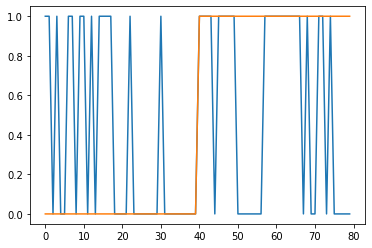

In [ ]:
plt.plot(model.predict_classes(x_test))
plt.plot(y_test_orig)
model.evaluate(x_test, y_test_orig)